<a href="https://colab.research.google.com/github/BHUVANA535/sentiment_analysis/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test_features.csv')

In [3]:
id = test.ID

In [4]:
train.head()

,ID,Text,Category
0,969,@JuliaBradbury @SimonCalder @walsop @HodderPRI...,0
1,241,or here https://t.co/R2tO79Easn … .An in house...,1
2,820,@britshmuseum @thehistoryguy Gosh periscope is...,2
3,693,@Ophiolatrist britishmuseum The stupid #French...,1
4,421,@SassyClde We won't stop til @britishmuseum du...,1


In [5]:
test.head()

,ID,Text
0,1861,Goodbye @kettlesyard see you in .25 years! htt...
1,354,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
2,1334,Fantastic @johnmcdonnellMP standing up for wor...
3,906,"@BBC_Culture @PlymouthMuseum Oh dear, why not ..."
4,1290,@britishmuseum @TripAdvisor it is !


In [6]:
train=train.drop(['ID'],axis=1)

In [7]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if not isinstance(text, str):
        text = ""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = text.lower()
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    return text

train['Text'] = train['Text'].apply(clean_text)
test['Text'] = test['Text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Text        0
Category    0
dtype: int64


<ipython-input-8-7a1aff9e79ab>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


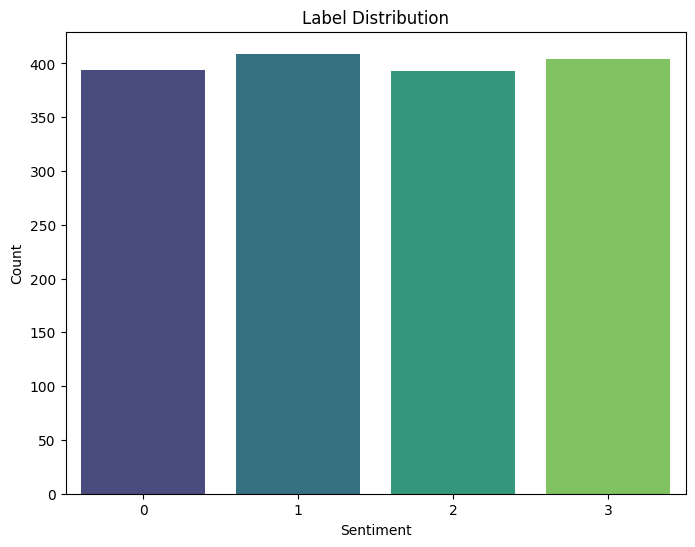

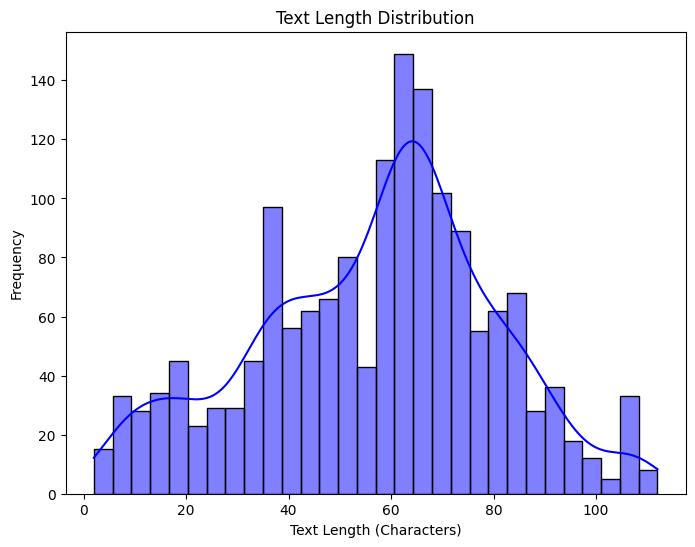

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Check for null values
print(train.isnull().sum())

# Distribution of Labels
label_counts = train['Category'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Label Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Text Length Distribution
train['Text_length'] = train['Text'].apply(len)
plt.figure(figsize=(8, 6))
sns.histplot(train['Text_length'], bins=30, kde=True, color='blue')
plt.title('Text Length Distribution')
plt.xlabel('Text Length (Characters)')
plt.ylabel('Frequency')
plt.show()

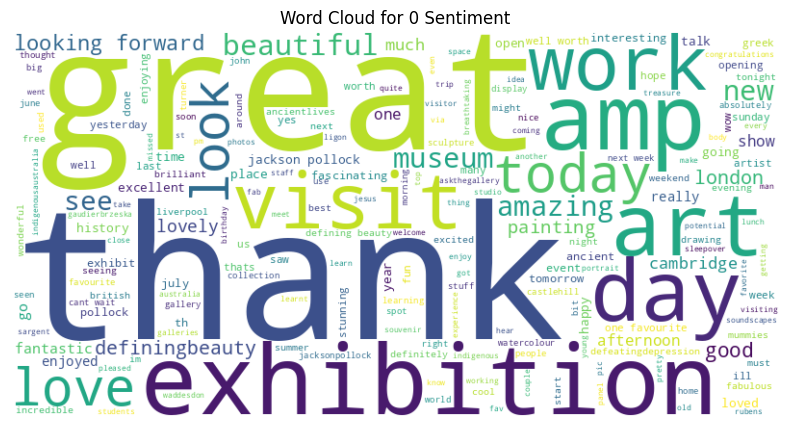

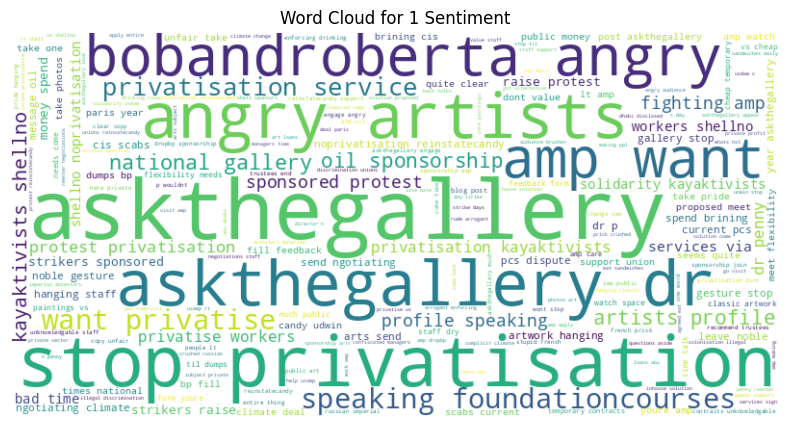

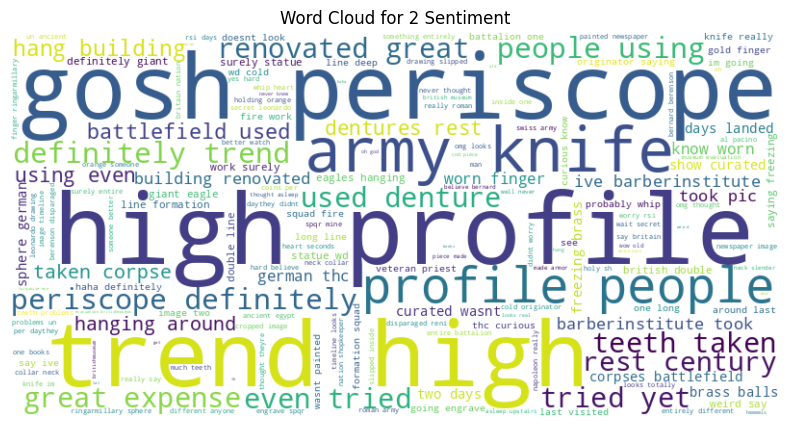

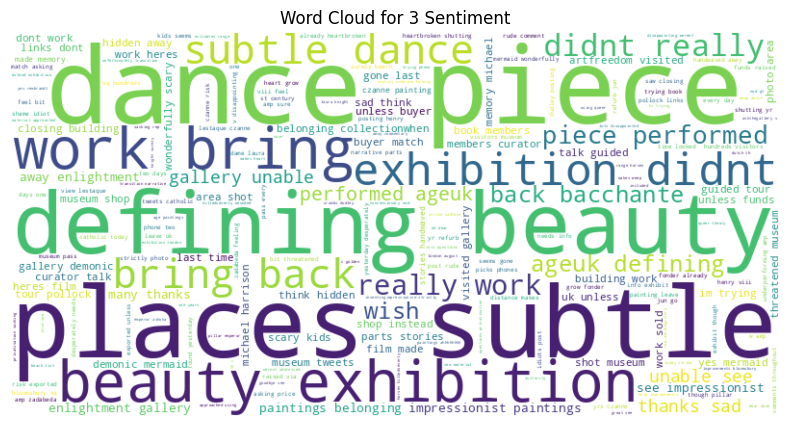

In [9]:
# Word Cloud for Each Sentiment
for sentiment in train['Category'].unique():
    sentiment_data = train[train['Category'] == sentiment]
    text = " ".join(text for text in sentiment_data['Text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment} Sentiment')
    plt.axis('off')
    plt.show()

In [10]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, train_labels, val_labels = train_test_split(
    train['Text'], train['Category'], test_size=0.2, random_state=42
)

In [11]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [12]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [13]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
print(f"Training size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Training size: 1280
Validation size: 320


In [15]:
train_labels = train_labels.reset_index(drop=True)
val_labels = val_labels.reset_index(drop=True)

In [16]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels  # Make sure this is a list, not a pandas Series

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])  # Accessing directly using indexing
        return item


In [17]:
print(len(train_encodings['input_ids']), len(train_labels))

1280 1280


In [18]:
problematic_idx = 198  # From the error message
print(train_labels.iloc[problematic_idx])  # If it's a Pandas Series
print(train_encodings['input_ids'][problematic_idx])  # Verify the encoding exists

0
[101, 2428, 5632, 9465, 3669, 7446, 2831, 3041, 2651, 4538, 5621, 27295, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [19]:
train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [20]:
sample = train_dataset[0]
print(sample)  # Should contain 'input_ids', 'attention_mask', and 'labels'

{'input_ids': tensor([  101, 14017,  2401, 15780, 10905,  4817, 29068,  5130,  1054,  3554,
        23713,  2215, 26927, 20203,  3366,  3667,  5806,  3630,  2053, 18098,
        11444,  7315,  3370,   102,     0,     0]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        0, 0]), 'labels': tensor(1)}


In [21]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    report_to="none",
    num_train_epochs=7,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.548800,0.482199
2,0.072300,0.086860
3,0.040700,0.101978
4,0.001500,0.097337
5,0.000900,0.058150
6,0.000700,0.072850
7,0.000700,0.077272


TrainOutput(global_step=560, training_loss=0.18554119519955878, metrics={'train_runtime': 91.5239, 'train_samples_per_second': 97.898, 'train_steps_per_second': 6.119, 'total_flos': 119717679943680.0, 'train_loss': 0.18554119519955878, 'epoch': 7.0})

In [22]:
from torch.utils.data import DataLoader

val_loader = DataLoader(val_dataset, batch_size=64)

In [23]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

model.eval()
predictions, true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(batch['labels'].cpu().numpy())

In [24]:
accuracy = accuracy_score(true_labels, predictions)
precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9844
Precision: 0.9849
Recall: 0.9844
F1 Score: 0.9844


In [25]:
precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions, average=None)

for i, (p, r, f, s) in enumerate(zip(precision, recall, f1, support)):
    print(f"Class {i} - Precision: {p:.4f}, Recall: {r:.4f}, F1: {f:.4f}, Support: {s}")

Class 0 - Precision: 1.0000, Recall: 0.9643, F1: 0.9818, Support: 84
Class 1 - Precision: 0.9697, Recall: 1.0000, F1: 0.9846, Support: 64
Class 2 - Precision: 0.9651, Recall: 1.0000, F1: 0.9822, Support: 83
Class 3 - Precision: 1.0000, Recall: 0.9775, F1: 0.9886, Support: 89


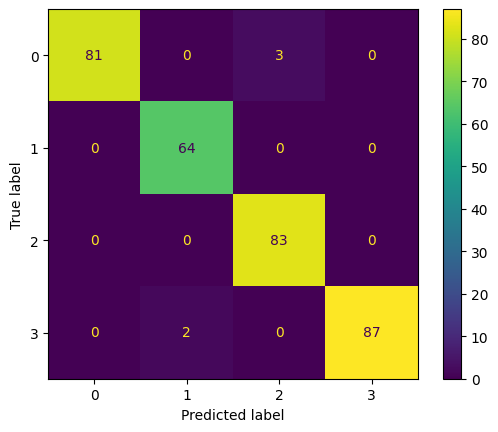

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(true_labels, predictions, display_labels=[0, 1, 2, 3])
plt.show()

In [27]:
class TestDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings['input_ids'])

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        return item

In [28]:
# Assuming test_df is your test DataFrame
test_texts = test['Text']

# Tokenize the test data
test_encodings = tokenizer(list(test_texts), truncation=True, padding=True, max_length=128)

# Use the new TestDataset class for the test set
test_dataset = TestDataset(test_encodings)
test_loader = DataLoader(test_dataset, batch_size=64)

# Make predictions
model.eval()
test_predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = {key: val.to(device) for key, val in batch.items()}
        outputs = model(**batch)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        test_predictions.extend(preds.cpu().numpy())

# Prepare the submission
submission = pd.DataFrame({
    'ID': test['ID'],
    'Prediction': test_predictions
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)
